# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B001ATMQK2,"undertheshrine ""undertheshrine""",1296691200,5,I bought this 6 pack because for the price tha...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

was way to hot for my blood, took a bite and did a jig  lol


In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

was way to hot for my blood took a bite and did a jig lol


In [21]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [22]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 87773/87773 [00:26<00:00, 3336.81it/s]


In [23]:
preprocessed_reviews[1500]

'way hot blood took bite jig lol'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [24]:
## Similartly you can do preprocessing for review summary also.

# [4] Featurization

## [4.1] BAG OF WORDS

In [25]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaaaaaaaa', 'aaaaaaaaaaaaaaa', 'aaaaaaahhhhhh', 'aaaaaaarrrrrggghhh', 'aaaaaawwwwwwwwww', 'aaaaah']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (87773, 54904)
the number of unique words  54904


## [4.2] Bi-Grams and n-Grams.

In [26]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (87773, 5000)
the number of unique words including both unigrams and bigrams  5000


## [4.3] TF-IDF

In [27]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['aa', 'aafco', 'aback', 'abandon', 'abandoned', 'abdominal', 'ability', 'able', 'able add', 'able brew']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (87773, 51709)
the number of unique words including both unigrams and bigrams  51709


## [4.4] Word2Vec

In [28]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [29]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.
# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('fantastic', 0.8517484068870544), ('terrific', 0.8488619327545166), ('awesome', 0.8456202149391174), ('good', 0.8308383822441101), ('excellent', 0.8183407783508301), ('perfect', 0.7778580188751221), ('wonderful', 0.775962233543396), ('amazing', 0.7507823705673218), ('nice', 0.7112433910369873), ('decent', 0.7027169466018677)]
[('greatest', 0.8226511478424072), ('best', 0.7392735481262207), ('tastiest', 0.7321904301643372), ('disgusting', 0.64337158203125), ('nastiest', 0.6155920028686523), ('coolest', 0.6126624941825867), ('surpass', 0.6104373931884766), ('terrible', 0.5980287194252014), ('closest', 0.5973566770553589), ('awful', 0.597038745880127)]


In [30]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  17386
sample words  ['dogs', 'loves', 'chicken', 'product', 'china', 'wont', 'buying', 'anymore', 'hard', 'find', 'products', 'made', 'usa', 'one', 'isnt', 'bad', 'good', 'take', 'chances', 'till', 'know', 'going', 'imports', 'love', 'saw', 'pet', 'store', 'tag', 'attached', 'regarding', 'satisfied', 'safe', 'infestation', 'literally', 'everywhere', 'flying', 'around', 'kitchen', 'bought', 'hoping', 'least', 'get', 'rid', 'weeks', 'fly', 'stuck', 'squishing', 'buggers', 'success', 'rate']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [31]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████| 87773/87773 [02:47<00:00, 524.85it/s]

87773
50


#### [4.4.1.2] TFIDF weighted W2v

In [32]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [33]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 87773/87773 [32:15<00:00, 45.34it/s]  


# [5] Assignment 9: Random Forests

<ol>
    <li><strong>Apply Random Forests & GBDT on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning (Consider two hyperparameters: n_estimators & max_depth)</strong>
    <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Get top 20 important features and represent them in a word cloud. Do this for BOW & TFIDF.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='3d_plot.JPG' width=500px> with X-axis as <strong>n_estimators</strong>, Y-axis as <strong>max_depth</strong>, and Z-axis as <strong>AUC Score</strong> , we have given the notebook which explains how to plot this 3d plot, you can find it in the same drive <i>3d_scatter_plot.ipynb</i></li>
            <p style="text-align:center;font-size:30px;color:red;"><strong>(or)</strong></p> <br>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='heat_map.JPG' width=300px> <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heat maps</a> with rows as <strong>n_estimators</strong>, columns as <strong>max_depth</strong>, and values inside the cell representing <strong>AUC Score</strong> </li>
    <li>You choose either of the plotting techniques out of 3d plot or heat map</li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
    </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

## [5.1] Applying RF

### [5.1.1] Applying Random Forests on BOW,<font color='red'> SET 1</font>

In [34]:
# Please write all the code with proper documentation
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

x=preprocessed_reviews
y=np.array(final['Score'])

from sklearn.model_selection import train_test_split
#train data
x1, x_test, y1, y_test = train_test_split(x,y,test_size=0.33, random_state=42)
#cv data
x_train, x_cv, y_train, y_cv = train_test_split(x1,y1,test_size=0.33, random_state=42)

#bow_vectorizery
vect=CountVectorizer()
x_train1=vect.fit_transform(x1)
x_train2=vect.fit_transform(x_train)
x_cv2=vect.transform(x_cv)
x_test2=vect.transform(x_test)

In [35]:
#RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
clsfr=RandomForestClassifier(n_jobs=-1)
param_grid = { 
    'n_estimators':[50,100,300,500,800,1000],
    'max_depth' : [1,5,10,50,100,500,1000] 
}
cv= GridSearchCV(estimator=clsfr, param_grid=param_grid, scoring='accuracy', cv= 3,return_train_score=True)
cv.fit(x_train1, y1)

GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=-1,
                                              oob_score=False,
                                              random_

best hyperparameters are {'max_depth': 500, 'n_estimators': 50}
best score schieved is 0.8718859900605428


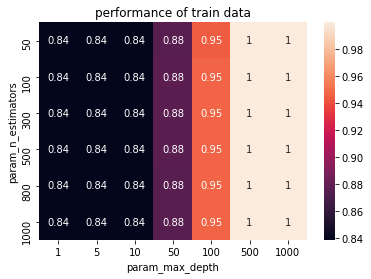

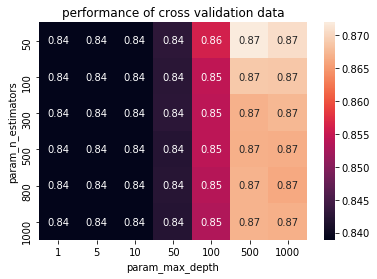

In [36]:
good_est1=cv.best_params_['n_estimators']
good_dept1=cv.best_params_['max_depth']

print("best hyperparameters are "+str(cv.best_params_))
print("best score schieved is "+str(cv.best_score_))

results=pd.DataFrame(cv.cv_results_)
train_score=results["mean_train_score"]
cv_score=results["mean_test_score"]

#https://seaborn.pydata.org/generated/seaborn.heatmap.html
#plot on train data
flights = results.pivot("param_n_estimators", "param_max_depth", "mean_train_score")
ax = sns.heatmap(flights,annot=True)
ax.set_title('performance of train data')
plt.show()
#plot on cv data
flights = results.pivot("param_n_estimators", "param_max_depth", "mean_test_score")
ax = sns.heatmap(flights,annot=True)
ax.set_title('performance of cross validation data')
plt.show()

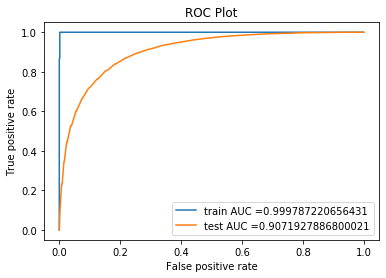

In [37]:
from sklearn.metrics import roc_curve, auc
clf = RandomForestClassifier(n_estimators = good_est1, max_depth =good_dept1)
clf.fit(x_train2,y_train)
train_fpr, train_tpr, thresholds = roc_curve(y_train, clf.predict_proba(x_train2)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, clf.predict_proba(x_test2)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC Plot")
plt.show()
auc1=str(auc(test_fpr, test_tpr))

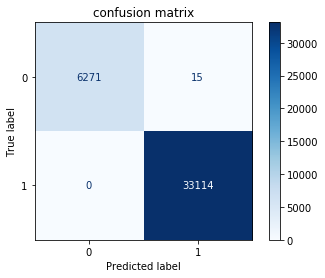

In [38]:
#confusion matrix for train data

#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(clf,x_train2,y_train,values_format='g',cmap=plt.cm.Blues)
plt.title('confusion matrix')
plt.show()

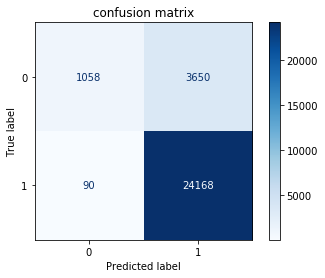

In [39]:
#confusion matrix for test data

#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(clf,x_test2,y_test,values_format='g',cmap=plt.cm.Blues)
plt.title('confusion matrix')
plt.show()

### [5.1.2] Wordcloud of top 20 important features from<font color='red'> SET 1</font>

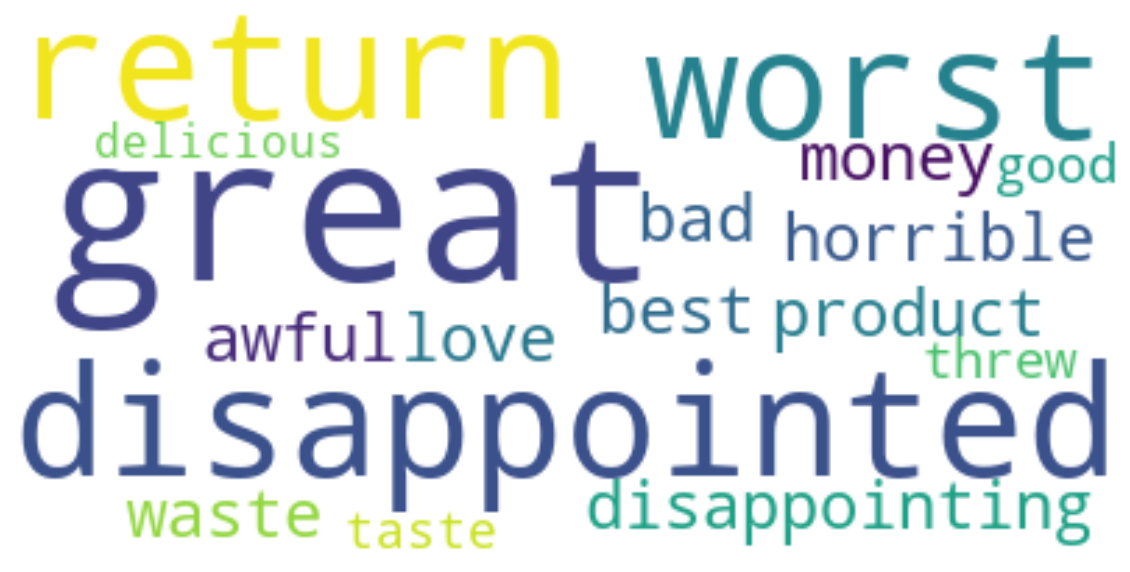

In [40]:
#https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
#used above link for thsi part of the code and modified it for the requirements
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]
# print("Feature ranking:")
imp_words=''
for f in range(x_train2.shape[1]):
    if f>=20:
        break
    imp_words+=vect.get_feature_names()[indices[f]]+' '
    #print("%d.  %s (%f)" % (f + 1, vect.get_feature_names()[indices[f]], importances[indices[f]]))


#https://www.pluralsight.com/guides/natural-language-processing-visualizing-text-data-using-word-cloud
#used the above link for this code
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
wordcloud_spam = WordCloud(background_color="white").generate(imp_words)
plt.figure(figsize = (20,20))
plt.imshow(wordcloud_spam, interpolation='bilinear')
plt.axis("off")
plt.show()

### [5.1.3] Applying Random Forests on TFIDF,<font color='red'> SET 2</font>

In [41]:
# Please write all the code with proper documentation
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

x=preprocessed_reviews
y=np.array(final['Score'])

from sklearn.model_selection import train_test_split
#train data
x1, x_test, y1, y_test = train_test_split(x,y,test_size=0.33, random_state=42)
#cv data
x_train, x_cv, y_train, y_cv = train_test_split(x1,y1,test_size=0.33, random_state=42)

#bow_vectorizer
vect=TfidfVectorizer()
x_train1=vect.fit_transform(x1)
x_train2=vect.fit_transform(x_train)
x_cv2=vect.transform(x_cv)
x_test2=vect.transform(x_test)

In [42]:
#RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
clsfr=RandomForestClassifier(n_jobs=-1)
param_grid = { 
    'n_estimators':[50,100,300,500,800,1000],
    'max_depth' : [1,5,10,50,100,500,1000] 
}
cv= GridSearchCV(estimator=clsfr, param_grid=param_grid, scoring='accuracy', cv= 3,return_train_score=True)
cv.fit(x_train1, y1)

GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=-1,
                                              oob_score=False,
                                              random_

best hyperparameters are {'max_depth': 500, 'n_estimators': 50}
best score schieved is 0.8664274588117928


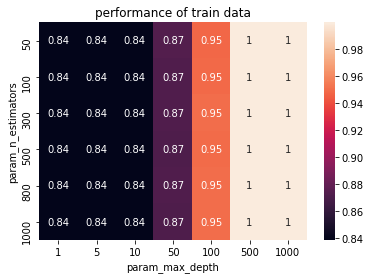

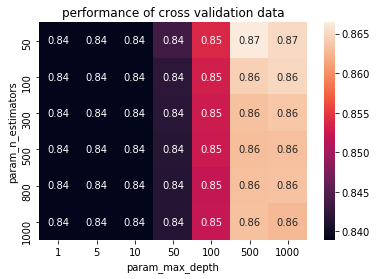

In [43]:
good_est2=cv.best_params_['n_estimators']
good_dept2=cv.best_params_['max_depth']

print("best hyperparameters are "+str(cv.best_params_))
print("best score schieved is "+str(cv.best_score_))

results=pd.DataFrame(cv.cv_results_)
train_score=results["mean_train_score"]
cv_score=results["mean_test_score"]

#https://seaborn.pydata.org/generated/seaborn.heatmap.html
#plot on train data
flights = results.pivot("param_n_estimators", "param_max_depth", "mean_train_score")
ax = sns.heatmap(flights,annot=True)
ax.set_title('performance of train data')
plt.show()
#plot on cv data
flights = results.pivot("param_n_estimators", "param_max_depth", "mean_test_score")
ax = sns.heatmap(flights,annot=True)
ax.set_title('performance of cross validation data')
plt.show()

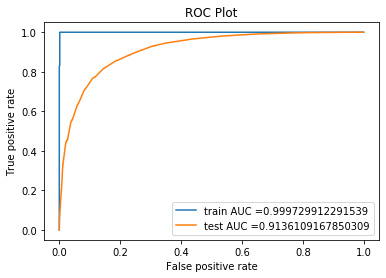

In [44]:
from sklearn.metrics import roc_curve, auc
clf = RandomForestClassifier(n_estimators = good_est2, max_depth =good_dept2)
clf.fit(x_train2,y_train)
train_fpr, train_tpr, thresholds = roc_curve(y_train, clf.predict_proba(x_train2)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, clf.predict_proba(x_test2)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC Plot")
plt.show()
auc2=str(auc(test_fpr, test_tpr))

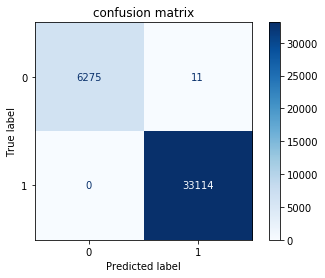

In [45]:
#confusion matrix for train data

#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(clf,x_train2,y_train,values_format='g',cmap=plt.cm.Blues)
plt.title('confusion matrix')
plt.show()

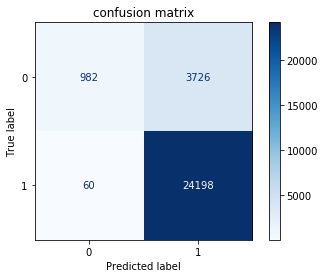

In [46]:
#confusion matrix for test data

#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(clf,x_test2,y_test,values_format='g',cmap=plt.cm.Blues)
plt.title('confusion matrix')
plt.show()

### [5.1.4] Wordcloud of top 20 important features from<font color='red'> SET 2</font>

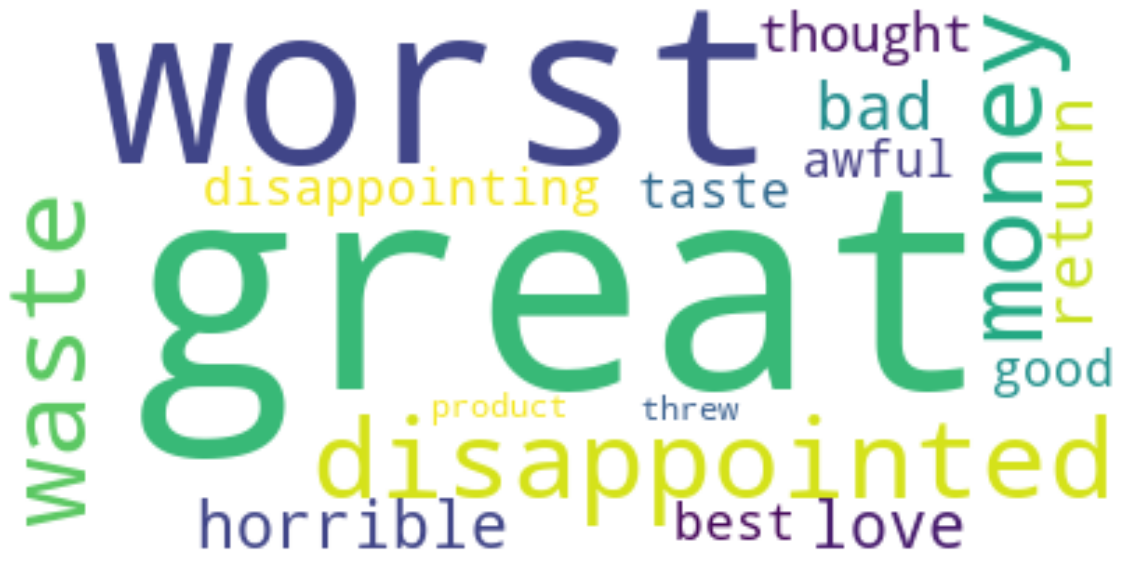

In [47]:
# Please write all the code with proper documentation
#https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
#used above link for thsi part of the code and modified it for the requirements
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]
# print("Feature ranking:")
imp_words=''
for f in range(x_train2.shape[1]):
    if f>=20:
        break
    imp_words+=vect.get_feature_names()[indices[f]]+' '
    #print("%d.  %s (%f)" % (f + 1, vect.get_feature_names()[indices[f]], importances[indices[f]]))


#https://www.pluralsight.com/guides/natural-language-processing-visualizing-text-data-using-word-cloud
#used the above link for this code
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
wordcloud_spam = WordCloud(background_color="white").generate(imp_words)
plt.figure(figsize = (20,20))
plt.imshow(wordcloud_spam, interpolation='bilinear')
plt.axis("off")
plt.show()

### [5.1.5] Applying Random Forests on AVG W2V,<font color='red'> SET 3</font>

In [48]:
list_of_sentance_train=[]
for sentance in x_train:
    list_of_sentance_train.append(sentance.split())
# average Word2Vec
# compute average word2vec for each review.
x_train2 = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_train): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    x_train2.append(sent_vec)
x_train2 = np.array(x_train2)
print(x_train2.shape)
print(x_train2[0])

list_of_sentance_cv=[]
for sentance in x_cv:
    list_of_sentance_cv.append(sentance.split())
# average Word2Vec
# compute average word2vec for each review.
x_cv2 = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_cv): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    x_cv2.append(sent_vec)
x_cv2 = np.array(x_cv2)
print(x_cv2.shape)
print(x_cv2[0])

list_of_sentance_test=[]
for sentance in x_test:
    list_of_sentance_test.append(sentance.split())
# average Word2Vec
# compute average word2vec for each review.
x_test2 = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    x_test2.append(sent_vec)
x_test2 = np.array(x_test2)
print(x_test2.shape)
print(x_test2[0])

100%|██████████| 39400/39400 [01:10<00:00, 555.39it/s]


(39400, 50)
[-0.13442123  0.93149839 -0.15544006 -1.12399984  0.1824613  -0.35014059
  0.14224982  0.25678564 -0.71178047  0.15668318 -0.02071989 -0.23065076
 -0.75602586 -0.84661794 -0.27188161 -0.91985031  0.1922932   0.23641167
 -0.36354222  0.08958033 -0.30846735 -0.2075348   0.56360962 -0.6673386
  0.01360539  0.44217739  0.11917964  0.53370856 -0.73481181 -0.51524947
  0.45107782 -0.21661204  0.29607474 -0.59325393  1.85046539 -0.98945079
 -0.33550429 -0.99017914  0.91552492  0.89868903 -0.20613736 -0.28493566
 -0.30100348  0.00252013 -0.25929743  0.97912574 -0.28259183 -1.06284798
  0.35032476  0.20758647]


  0%|          | 0/28966 [00:00<?, ?it/s]

(19407, 50)
[ 1.24310983e-01  4.97531049e-01 -3.65057842e-02 -8.10192059e-01
  6.80933694e-01 -1.69048489e-03 -2.02685921e-01 -1.01763622e-01
 -2.12132417e-01  3.30274229e-01 -3.18256383e-01  2.84982041e-01
  4.13763960e-01 -6.04536282e-01  8.17107977e-02 -3.19389688e-02
  6.60772905e-01  6.29443675e-05 -5.59223980e-01 -8.50489015e-02
  3.61408688e-01 -5.83927711e-01 -1.80271288e-01 -8.18036934e-01
  3.46983383e-01  8.81772067e-02  1.68215675e-01  6.01129478e-02
 -7.67143779e-01 -5.08355316e-01  3.68338407e-01 -2.89282935e-01
  6.92135302e-01 -3.50303333e-01  1.03953917e+00  1.89624621e-01
 -3.16293774e-01  7.17511573e-02  4.75217496e-01  7.12219571e-01
  9.42769355e-02 -7.54590785e-01  6.33398384e-01  2.09111450e-01
 -7.95041211e-03 -2.81826521e-01 -1.04440817e+00 -1.06643010e+00
  1.48303954e-01  4.16314323e-02]


100%|██████████| 28966/28966 [00:54<00:00, 531.12it/s]

(28966, 50)
[ 0.54877199  1.59222682 -0.3469823   0.73044943  0.46637478 -0.07383522
 -0.67848339 -0.62757962 -1.71750334  0.9996432  -0.80598101 -0.45701006
 -0.37580769 -0.30004706 -2.44440206  0.25727517 -0.37842402 -0.69938616
 -0.31032119 -0.50276559 -0.31011204 -0.52913687  0.59306131 -0.00670163
  0.26250092  0.33243494 -0.72385921 -0.51507951 -0.65134462 -0.0972358
  1.42362378 -0.07138068  0.37593115 -0.29789607  0.37816811 -1.53020157
 -0.11324716  0.27401269 -0.3619706   0.49661131  0.58249041  0.23117892
 -1.0942127  -0.15052842  0.73816342  0.47262417 -0.25248573 -1.91116155
 -0.77684181 -0.16225035]


In [49]:
#RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
clsfr=RandomForestClassifier(n_jobs=-1)
param_grid = { 
    'n_estimators':[50,100,300,500,800,1000],
    'max_depth' : [1,5,10,50,100,500,1000] 
}
cv= GridSearchCV(estimator=clsfr, param_grid=param_grid, scoring='accuracy', cv= 3,return_train_score=True)
cv.fit(x_train2, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=-1,
                                              oob_score=False,
                                              random_

best hyperparameters are {'max_depth': 500, 'n_estimators': 800}
best score schieved is 0.8806091484969772


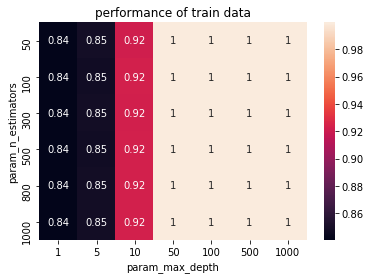

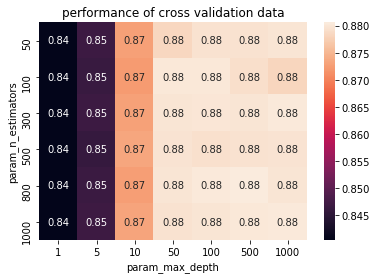

In [50]:
good_est3=cv.best_params_['n_estimators']
good_dept3=cv.best_params_['max_depth']

print("best hyperparameters are "+str(cv.best_params_))
print("best score schieved is "+str(cv.best_score_))

results=pd.DataFrame(cv.cv_results_)
train_score=results["mean_train_score"]
cv_score=results["mean_test_score"]

#https://seaborn.pydata.org/generated/seaborn.heatmap.html
#plot on train data
flights = results.pivot("param_n_estimators", "param_max_depth", "mean_train_score")
ax = sns.heatmap(flights,annot=True)
ax.set_title('performance of train data')
plt.show()
#plot on cv data
flights = results.pivot("param_n_estimators", "param_max_depth", "mean_test_score")
ax = sns.heatmap(flights,annot=True)
ax.set_title('performance of cross validation data')
plt.show()

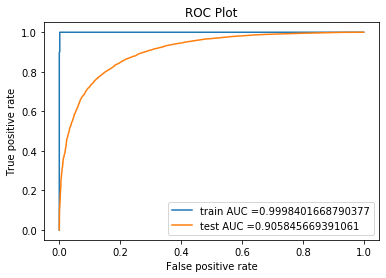

In [51]:
from sklearn.metrics import roc_curve, auc
clf = RandomForestClassifier(n_estimators = good_est3, max_depth =good_dept3)
clf.fit(x_train2,y_train)
train_fpr, train_tpr, thresholds = roc_curve(y_train, clf.predict_proba(x_train2)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, clf.predict_proba(x_test2)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC Plot")
plt.show()
auc3=str(auc(test_fpr, test_tpr))

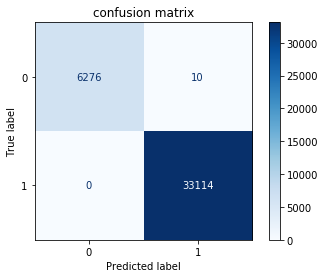

In [52]:
#confusion matrix for train data

#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(clf,x_train2,y_train,values_format='g',cmap=plt.cm.Blues)
plt.title('confusion matrix')
plt.show()

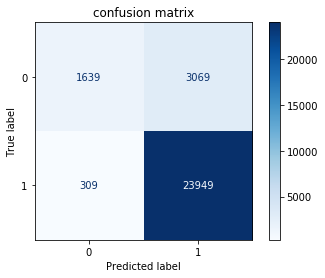

In [53]:
#confusion matrix for test data

#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(clf,x_test2,y_test,values_format='g',cmap=plt.cm.Blues)
plt.title('confusion matrix')
plt.show()

### [5.1.6] Applying Random Forests on TFIDF W2V,<font color='red'> SET 4</font>

In [54]:
# Please write all the code with proper documentation
list_of_sentance_train=[]
#w2v
for sentance in x_train:
    list_of_sentance_train.append(sentance.split())
w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)
#tf-idf
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(x_train)
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))
tfidf_feat = model.get_feature_names()

x_train2 = []; 
row=0;
for sent in tqdm(list_of_sentance_train):
    sent_vec = np.zeros(50)
    weight_sum =0; 
    for word in sent:
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    x_train2.append(sent_vec)
    row += 1
print(len(x_train2))
    
list_of_sentance_cv=[]
for sentance in x_cv:
    list_of_sentance_cv.append(sentance.split())
x_cv2 = []; 
row=0;
for sent in tqdm(list_of_sentance_cv):
    sent_vec = np.zeros(50)
    weight_sum =0; 
    for word in sent:
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0: 
        sent_vec /= weight_sum
    x_cv2.append(sent_vec)
    row += 1
print(len(x_cv2))

list_of_sentance_test=[]
for sentance in x_test:
    list_of_sentance_test.append(sentance.split())
x_test2 = []; 
row=0;
for sent in tqdm(list_of_sentance_test):
    sent_vec = np.zeros(50)
    weight_sum =0; 
    for word in sent:
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    x_test2.append(sent_vec)
    row += 1
print(len(x_test2))

  0%|          | 15/19407 [00:00<04:18, 75.12it/s]

39400


  0%|          | 12/28966 [00:00<04:10, 115.59it/s]

19407


100%|██████████| 28966/28966 [05:54<00:00, 81.70it/s] 

28966


In [55]:
#RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
clsfr=RandomForestClassifier(n_jobs=-1)
param_grid = { 
    'n_estimators':[50,100,300,500,800,1000],
    'max_depth' : [1,5,10,50,100,500,1000] 
}
cv= GridSearchCV(estimator=clsfr, param_grid=param_grid, scoring='accuracy', cv= 3,return_train_score=True)
cv.fit(x_train2, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=-1,
                                              oob_score=False,
                                              random_

best hyperparameters are {'max_depth': 500, 'n_estimators': 50}
best score schieved is 0.864568493603603


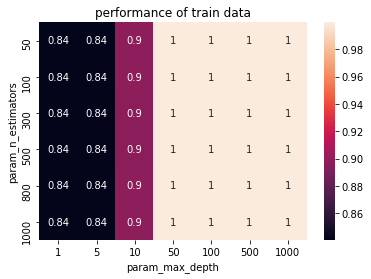

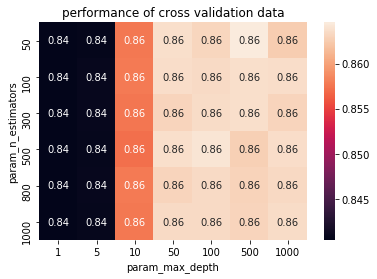

In [56]:
good_est4=cv.best_params_['n_estimators']
good_dept4=cv.best_params_['max_depth']

print("best hyperparameters are "+str(cv.best_params_))
print("best score schieved is "+str(cv.best_score_))

results=pd.DataFrame(cv.cv_results_)
train_score=results["mean_train_score"]
cv_score=results["mean_test_score"]

#https://seaborn.pydata.org/generated/seaborn.heatmap.html
#plot on train data
flights = results.pivot("param_n_estimators", "param_max_depth", "mean_train_score")
ax = sns.heatmap(flights,annot=True)
ax.set_title('performance of train data')
plt.show()
#plot on cv data
flights = results.pivot("param_n_estimators", "param_max_depth", "mean_test_score")
ax = sns.heatmap(flights,annot=True)
ax.set_title('performance of cross validation data')
plt.show()

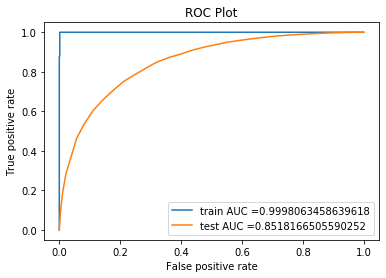

In [57]:
from sklearn.metrics import roc_curve, auc
clf = RandomForestClassifier(n_estimators = good_est4, max_depth =good_dept4)
clf.fit(x_train2,y_train)
train_fpr, train_tpr, thresholds = roc_curve(y_train, clf.predict_proba(x_train2)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, clf.predict_proba(x_test2)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC Plot")
plt.show()
auc4=str(auc(test_fpr, test_tpr))

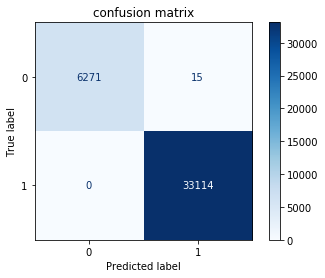

In [58]:
#confusion matrix for train data

#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(clf,x_train2,y_train,values_format='g',cmap=plt.cm.Blues)
plt.title('confusion matrix')
plt.show()

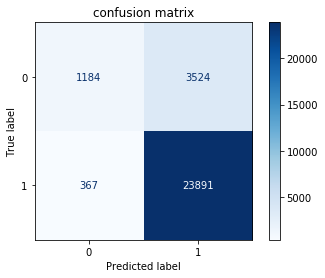

In [59]:
#confusion matrix for test data

#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(clf,x_test2,y_test,values_format='g',cmap=plt.cm.Blues)
plt.title('confusion matrix')
plt.show()

## [5.2] Applying GBDT using XGBOOST

### [5.2.1] Applying XGBOOST on BOW,<font color='red'> SET 1</font>

In [60]:
# Please write all the code with proper documentation
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

x=preprocessed_reviews
y=np.array(final['Score'])

from sklearn.model_selection import train_test_split
#train data
x1, x_test, y1, y_test = train_test_split(x,y,test_size=0.33, random_state=42)
#cv data
x_train, x_cv, y_train, y_cv = train_test_split(x1,y1,test_size=0.33, random_state=42)

#bow_vectorizery
vect=CountVectorizer()
x_train1=vect.fit_transform(x1)
x_train2=vect.fit_transform(x_train)
x_cv2=vect.transform(x_cv)
x_test2=vect.transform(x_test)

In [61]:
#RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
clsfr=XGBClassifier()
param_grid = { 
    'n_estimators':[50,100,300,500,800,1000],
    'max_depth' : [1,5,10,50,100,500,1000] 
}
cv= GridSearchCV(estimator=clsfr, param_grid=param_grid, scoring='accuracy', cv= 3,return_train_score=True)
cv.fit(x_train1, y1)

GridSearchCV(cv=3, error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estim...
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                                     subsample=None, tree_method=None,
                                     validate_parameters=False,

best hyperparameters are {'max_depth': 5, 'n_estimators': 800}
best score schieved is 0.9152482017511954


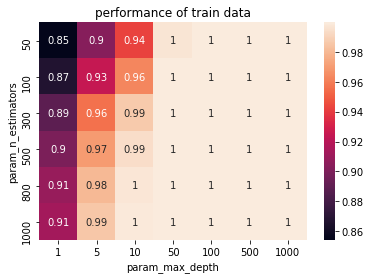

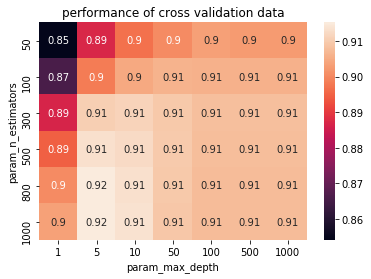

In [62]:
good_est5=cv.best_params_['n_estimators']
good_dept5=cv.best_params_['max_depth']

print("best hyperparameters are "+str(cv.best_params_))
print("best score schieved is "+str(cv.best_score_))

results=pd.DataFrame(cv.cv_results_)
train_score=results["mean_train_score"]
cv_score=results["mean_test_score"]

#https://seaborn.pydata.org/generated/seaborn.heatmap.html
#plot on train data
flights = results.pivot("param_n_estimators", "param_max_depth", "mean_train_score")
ax = sns.heatmap(flights,annot=True)
ax.set_title('performance of train data')
plt.show()
#plot on cv data
flights = results.pivot("param_n_estimators", "param_max_depth", "mean_test_score")
ax = sns.heatmap(flights,annot=True)
ax.set_title('performance of cross validation data')
plt.show()

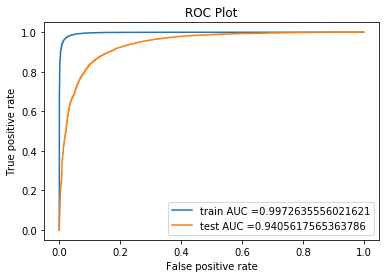

In [63]:
from sklearn.metrics import roc_curve, auc
clf = XGBClassifier(n_estimators = good_est5, max_depth =good_dept5)
clf.fit(x_train2,y_train)
train_fpr, train_tpr, thresholds = roc_curve(y_train, clf.predict_proba(x_train2)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, clf.predict_proba(x_test2)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC Plot")
plt.show()
auc5=str(auc(test_fpr, test_tpr))

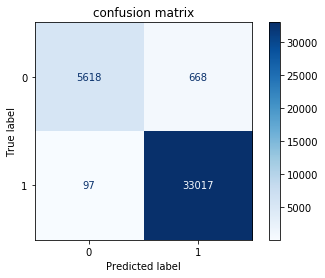

In [64]:
#confusion matrix for train data

#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(clf,x_train2,y_train,values_format='g',cmap=plt.cm.Blues)
plt.title('confusion matrix')
plt.show()

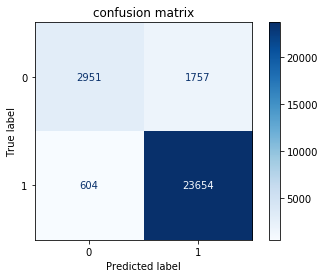

In [65]:
#confusion matrix for test data

#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(clf,x_test2,y_test,values_format='g',cmap=plt.cm.Blues)
plt.title('confusion matrix')
plt.show()

### [5.2.2] Applying XGBOOST on TFIDF,<font color='red'> SET 2</font>

In [66]:
# Please write all the code with proper documentation
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

x=preprocessed_reviews
y=np.array(final['Score'])

from sklearn.model_selection import train_test_split
#train data
x1, x_test, y1, y_test = train_test_split(x,y,test_size=0.33, random_state=42)
#cv data
x_train, x_cv, y_train, y_cv = train_test_split(x1,y1,test_size=0.33, random_state=42)

#bow_vectorizer
vect=TfidfVectorizer()
x_train1=vect.fit_transform(x1)
x_train2=vect.fit_transform(x_train)
x_cv2=vect.transform(x_cv)
x_test2=vect.transform(x_test)

In [67]:
#XGBClassifier
from sklearn.model_selection import GridSearchCV
clsfr=XGBClassifier()
param_grid = { 
    'n_estimators':[50,100,300,500,800,1000],
    'max_depth' : [1,5,10,50,100,500,1000] 
}
cv= GridSearchCV(estimator=clsfr, param_grid=param_grid, scoring='accuracy', cv= 3,return_train_score=True)
cv.fit(x_train1, y1)

GridSearchCV(cv=3, error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estim...
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                                     subsample=None, tree_method=None,
                                     validate_parameters=False,

best hyperparameters are {'max_depth': 5, 'n_estimators': 1000}
best score schieved is 0.9122553402309593


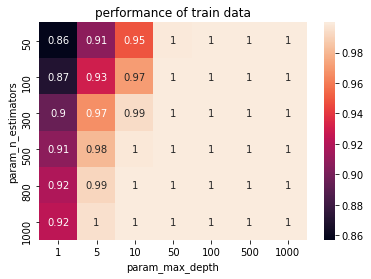

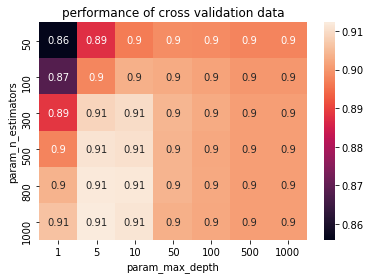

In [68]:
good_est6=cv.best_params_['n_estimators']
good_dept6=cv.best_params_['max_depth']

print("best hyperparameters are "+str(cv.best_params_))
print("best score schieved is "+str(cv.best_score_))

results=pd.DataFrame(cv.cv_results_)
train_score=results["mean_train_score"]
cv_score=results["mean_test_score"]

#https://seaborn.pydata.org/generated/seaborn.heatmap.html
#plot on train data
flights = results.pivot("param_n_estimators", "param_max_depth", "mean_train_score")
ax = sns.heatmap(flights,annot=True)
ax.set_title('performance of train data')
plt.show()
#plot on cv data
flights = results.pivot("param_n_estimators", "param_max_depth", "mean_test_score")
ax = sns.heatmap(flights,annot=True)
ax.set_title('performance of cross validation data')
plt.show()

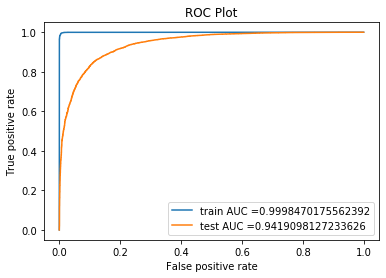

In [69]:
from sklearn.metrics import roc_curve, auc
clf = XGBClassifier(n_estimators = good_est6, max_depth =good_dept6)
clf.fit(x_train2,y_train)
train_fpr, train_tpr, thresholds = roc_curve(y_train, clf.predict_proba(x_train2)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, clf.predict_proba(x_test2)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC Plot")
plt.show()
auc6=str(auc(test_fpr, test_tpr))

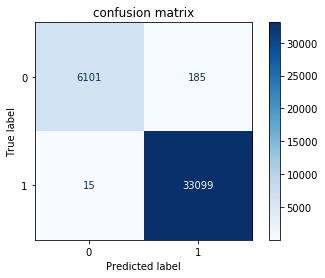

In [70]:
#confusion matrix for train data

#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(clf,x_train2,y_train,values_format='g',cmap=plt.cm.Blues)
plt.title('confusion matrix')
plt.show()

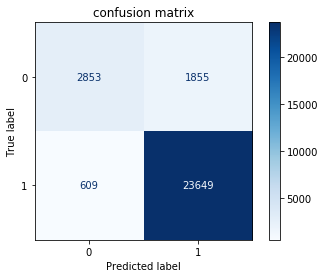

In [71]:
#confusion matrix for test data

#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(clf,x_test2,y_test,values_format='g',cmap=plt.cm.Blues)
plt.title('confusion matrix')
plt.show()

### [5.2.3] Applying XGBOOST on AVG W2V,<font color='red'> SET 3</font>

In [72]:
list_of_sentance_train=[]
for sentance in x_train:
    list_of_sentance_train.append(sentance.split())
# average Word2Vec
# compute average word2vec for each review.
x_train2 = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_train): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    x_train2.append(sent_vec)
x_train2 = np.array(x_train2)
print(x_train2.shape)
print(x_train2[0])

list_of_sentance_cv=[]
for sentance in x_cv:
    list_of_sentance_cv.append(sentance.split())
# average Word2Vec
# compute average word2vec for each review.
x_cv2 = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_cv): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    x_cv2.append(sent_vec)
x_cv2 = np.array(x_cv2)
print(x_cv2.shape)
print(x_cv2[0])

list_of_sentance_test=[]
for sentance in x_test:
    list_of_sentance_test.append(sentance.split())
# average Word2Vec
# compute average word2vec for each review.
x_test2 = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    x_test2.append(sent_vec)
x_test2 = np.array(x_test2)
print(x_test2.shape)
print(x_test2[0])

  1%|          | 120/19407 [00:00<00:16, 1198.94it/s]

(39400, 50)
[ 0.36284035  0.49942867  0.37053218 -0.38044213  0.02667049  0.26459992
  0.3270302   0.80862816 -0.70992556  0.5137042   0.27667931 -0.09648413
  0.3097413  -0.62069077 -0.9034686   0.20608269 -0.40224871  0.46563379
 -0.64685     0.2086452   0.3400523   0.21674182  0.08010934 -0.17006453
  0.4954449   0.26216079 -0.21283656  0.50856187 -0.80733603 -0.43147581
  0.8083665  -0.30101794  0.35318266 -0.19101558  0.9392495  -0.12960671
 -0.06642012 -0.83065301  0.91410225  0.34722912 -0.31495981 -0.49616794
 -0.34394273 -0.15524471  0.17564237  0.35147069  0.01508994 -1.45032633
 -0.05724322  0.34268241]


  0%|          | 0/28966 [00:00<?, ?it/s]

(19407, 50)
[ 0.63292593 -0.0282502   0.16441936  0.11200197 -0.04525589 -0.14067845
 -0.4276301   0.5021465  -0.52969976  0.47908746  0.44018919 -0.12475024
  0.44384539 -0.44395811 -0.03539294  0.04505558  0.12508123  0.34971571
 -0.27756556 -0.1729092   0.18705626 -0.52270073 -0.426043   -0.51014515
  0.5123446  -0.06679392 -0.17216068  0.39009164 -0.26131268 -0.19221555
  0.54205765 -0.36099401  0.65357918 -0.12593611  0.96628701  0.4153724
 -0.00649427  0.45783364  0.81794012  0.61838133 -0.21953113 -0.39563241
  0.29884488  0.06295901  0.09423763 -0.59505051 -0.44527615 -1.26218381
 -0.08180986 -0.29615969]


100%|██████████| 28966/28966 [00:37<00:00, 777.14it/s]

(28966, 50)
[ 1.64269904  0.10261278  1.19263417  1.12573803 -0.30646803 -0.42233284
 -0.33487711 -0.03478789 -0.85387931  0.16741656 -0.76772903 -0.13925254
 -0.28867275 -0.87942617 -1.6170902   0.32966849 -0.7315576  -0.40581268
  0.03986232 -0.60983086  1.09253549 -0.69296425  0.72452845  1.13288872
 -0.24499797  0.7730174  -0.02654922 -0.22941601 -0.59870844 -0.22526924
  0.72705761 -0.62850972  1.26587228  0.0769556   0.05556364 -0.66571247
  0.81730658  0.26382441  0.26705391 -0.39238223  0.4456337  -0.22872507
 -1.03100141  0.48179364  0.46934577 -0.30266279  0.77091588 -1.26119053
 -0.37908894  0.05226463]


In [73]:
#RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
clsfr=XGBClassifier()
param_grid = { 
    'n_estimators':[50,100,300,500,800,1000],
    'max_depth' : [1,5,10,50,100,500,1000] 
}
cv= GridSearchCV(estimator=clsfr, param_grid=param_grid, scoring='accuracy', cv= 3,return_train_score=True)
cv.fit(x_train2, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estim...
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                                     subsample=None, tree_method=None,
                                     validate_parameters=False,

best hyperparameters are {'max_depth': 5, 'n_estimators': 1000}
best score schieved is 0.8832487688197365


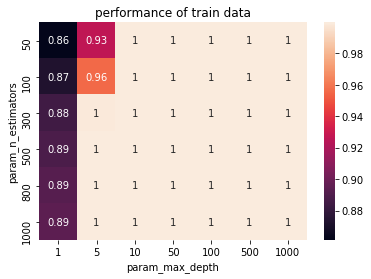

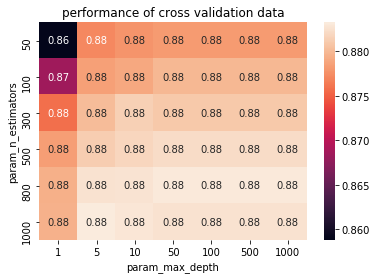

In [74]:
good_est7=cv.best_params_['n_estimators']
good_dept7=cv.best_params_['max_depth']

print("best hyperparameters are "+str(cv.best_params_))
print("best score schieved is "+str(cv.best_score_))

results=pd.DataFrame(cv.cv_results_)
train_score=results["mean_train_score"]
cv_score=results["mean_test_score"]

#https://seaborn.pydata.org/generated/seaborn.heatmap.html
#plot on train data
flights = results.pivot("param_n_estimators", "param_max_depth", "mean_train_score")
ax = sns.heatmap(flights,annot=True)
ax.set_title('performance of train data')
plt.show()
#plot on cv data
flights = results.pivot("param_n_estimators", "param_max_depth", "mean_test_score")
ax = sns.heatmap(flights,annot=True)
ax.set_title('performance of cross validation data')
plt.show()

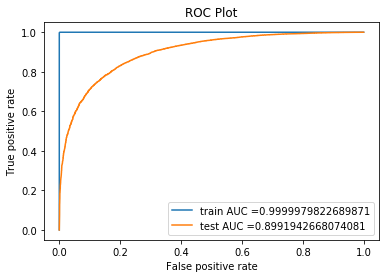

In [75]:
from sklearn.metrics import roc_curve, auc
clf=XGBClassifier(n_estimators = good_est7, max_depth =good_dept7)
clf.fit(x_train2,y_train)
train_fpr, train_tpr, thresholds = roc_curve(y_train, clf.predict_proba(x_train2)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, clf.predict_proba(x_test2)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC Plot")
plt.show()
auc7=str(auc(test_fpr, test_tpr))

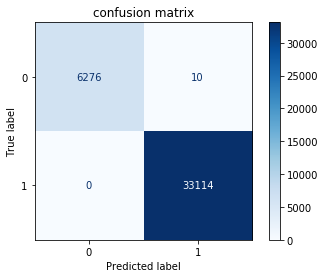

In [76]:
#confusion matrix for train data

#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(clf,x_train2,y_train,values_format='g',cmap=plt.cm.Blues)
plt.title('confusion matrix')
plt.show()

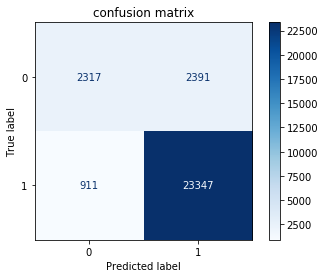

In [77]:
#confusion matrix for test data

#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(clf,x_test2,y_test,values_format='g',cmap=plt.cm.Blues)
plt.title('confusion matrix')
plt.show()

### [5.2.4] Applying XGBOOST on TFIDF W2V,<font color='red'> SET 4</font>

In [78]:
# Please write all the code with proper documentation
list_of_sentance_train=[]
#w2v
for sentance in x_train:
    list_of_sentance_train.append(sentance.split())
w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)
#tf-idf
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(x_train)
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))
tfidf_feat = model.get_feature_names()

x_train2 = []; 
row=0;
for sent in tqdm(list_of_sentance_train):
    sent_vec = np.zeros(50)
    weight_sum =0; 
    for word in sent:
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    x_train2.append(sent_vec)
    row += 1
print(len(x_train2))
    
list_of_sentance_cv=[]
for sentance in x_cv:
    list_of_sentance_cv.append(sentance.split())
x_cv2 = []; 
row=0;
for sent in tqdm(list_of_sentance_cv):
    sent_vec = np.zeros(50)
    weight_sum =0; 
    for word in sent:
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0: 
        sent_vec /= weight_sum
    x_cv2.append(sent_vec)
    row += 1
print(len(x_cv2))

list_of_sentance_test=[]
for sentance in x_test:
    list_of_sentance_test.append(sentance.split())
x_test2 = []; 
row=0;
for sent in tqdm(list_of_sentance_test):
    sent_vec = np.zeros(50)
    weight_sum =0; 
    for word in sent:
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    x_test2.append(sent_vec)
    row += 1
print(len(x_test2))

x_train2=np.array(x_train2)
x_cv2=np.array(x_cv2)
x_test2=np.array(x_test2)

  0%|          | 11/19407 [00:00<06:05, 53.04it/s]

39400


  0%|          | 17/28966 [00:00<06:01, 80.02it/s]

19407


100%|██████████| 28966/28966 [07:38<00:00, 63.19it/s]


28966


In [79]:
#RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
clsfr=XGBClassifier()
param_grid = { 
    'n_estimators':[50,100,300,500,800,1000],
    'max_depth' : [1,5,10,50,100,500,1000] 
}
cv= GridSearchCV(estimator=clsfr, param_grid=param_grid, scoring='accuracy', cv= 3,return_train_score=True)
cv.fit(x_train2, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estim...
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                                     subsample=None, tree_method=None,
                                     validate_parameters=False,

best hyperparameters are {'max_depth': 10, 'n_estimators': 1000}
best score schieved is 0.8755837020751022


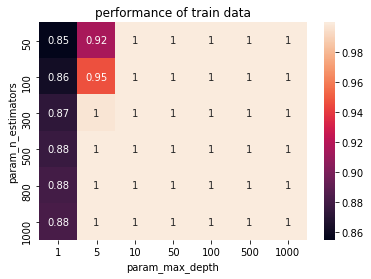

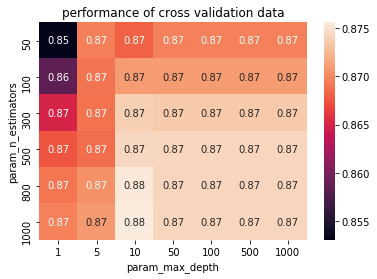

In [80]:
good_est8=cv.best_params_['n_estimators']
good_dept8=cv.best_params_['max_depth']

print("best hyperparameters are "+str(cv.best_params_))
print("best score schieved is "+str(cv.best_score_))

results=pd.DataFrame(cv.cv_results_)
train_score=results["mean_train_score"]
cv_score=results["mean_test_score"]

#https://seaborn.pydata.org/generated/seaborn.heatmap.html
#plot on train data
flights = results.pivot("param_n_estimators", "param_max_depth", "mean_train_score")
ax = sns.heatmap(flights,annot=True)
ax.set_title('performance of train data')
plt.show()
#plot on cv data
flights = results.pivot("param_n_estimators", "param_max_depth", "mean_test_score")
ax = sns.heatmap(flights,annot=True)
ax.set_title('performance of cross validation data')
plt.show()

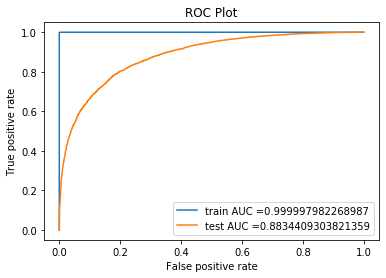

In [81]:
from sklearn.metrics import roc_curve, auc
clf=XGBClassifier(n_estimators = good_est8, max_depth =good_dept8)
clf.fit(x_train2,y_train)
train_fpr, train_tpr, thresholds = roc_curve(y_train, clf.predict_proba(x_train2)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, clf.predict_proba(x_test2)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC Plot")
plt.show()
auc8=str(auc(test_fpr, test_tpr))

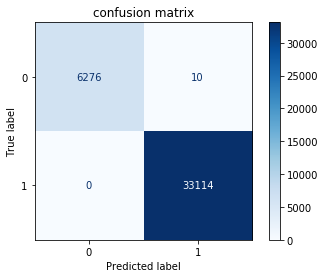

In [82]:
#confusion matrix for train data

#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(clf,x_train2,y_train,values_format='g',cmap=plt.cm.Blues)
plt.title('confusion matrix')
plt.show()

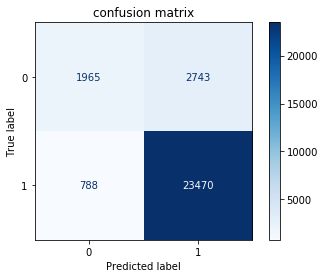

In [83]:
#confusion matrix for test data

#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(clf,x_test2,y_test,values_format='g',cmap=plt.cm.Blues)
plt.title('confusion matrix')
plt.show()

# [6] Conclusions

In [84]:
# Please compare all your models using Prettytable library
from prettytable import PrettyTable    
x = PrettyTable()
x.field_names = ["Model","Vectorizer","max_depth", "n_estimators", "AUC"]
x.add_row(['Random Forest','BOW',good_dept1,good_est1,auc1[:5]])
x.add_row(['Random Forest','TFIDF',good_dept2,good_est2,auc2[:5]])
x.add_row(['Random Forest','AVG W2vec',good_dept3,good_est3,auc3[:5]])
x.add_row(['Random Forest','TFIDF W2vec',good_dept4,good_est4,auc4[:5]])
x.add_row(['XGBOOST GBDT','Bow',good_dept5,good_est5,auc5[:5]])
x.add_row(['XGBOOST GBDT','TFIDF',good_dept6,good_est6,auc6[:5]])
x.add_row(['XGBOOST GBDT','AVG W2Vec',good_dept7,good_est7,auc7[:5]])
x.add_row(['XGBOOST GBDT','TFIDF W2Vec',good_dept8,good_est8,auc8[:5]])
print(x)

+---------------+-------------+-----------+--------------+-------+
|     Model     |  Vectorizer | max_depth | n_estimators |  AUC  |
+---------------+-------------+-----------+--------------+-------+
| Random Forest |     BOW     |    500    |      50      | 0.907 |
| Random Forest |    TFIDF    |    500    |      50      | 0.913 |
| Random Forest |  AVG W2vec  |    500    |     800      | 0.905 |
| Random Forest | TFIDF W2vec |    500    |      50      | 0.851 |
|  XGBOOST GBDT |     Bow     |     5     |     800      | 0.940 |
|  XGBOOST GBDT |    TFIDF    |     5     |     1000     | 0.941 |
|  XGBOOST GBDT |  AVG W2Vec  |     5     |     1000     | 0.899 |
|  XGBOOST GBDT | TFIDF W2Vec |     10    |     1000     | 0.883 |
+---------------+-------------+-----------+--------------+-------+
